## Load librarys

In [50]:
import numpy as np
import pandas as pd
import os
import sys
parentDir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(os.path.join(parentDir, "general_utils"))
import file_management

import matplotlib.pyplot as plt
import csv
import random
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from numpy.random import seed
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from collections import Counter
from data_preprocessing import data_preprocessing

seed(0)

In [15]:
import pickle

def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
        return data

In [16]:
df = load_pickle('Processed Data/QPCR_labelled_df_qpcr.pkl')
# replace nan values in the PCR column with 0
# df['PCR'] = df['PCR'].fillna(0)
# remove all rows with cluster_id == 65535
df = df.loc[df['cluster_id'] != 65535]
df

,C,B,G,Y,R,RE,N,N2,NDVI_1,NDVI_2,...,NPQI_4,NPQI_5,CLR,CLG,BNDVI,CTR1,cluster_id,Lats,Longs,PCR
29,60.384679,58.094153,51.333936,38.450394,42.554274,43.711153,63.485543,38.184771,0.197391,-0.054119,...,0.033620,0.038342,0.452388,0.236717,0.044344,0.704720,0,39.618415,2.581203,NaN
30,75.912168,70.238129,60.067095,43.741732,45.014058,53.268072,80.919397,49.011551,0.285114,0.042515,...,0.067594,0.077119,0.519098,0.347150,0.070663,0.592976,0,39.618415,2.581208,NaN
31,77.637444,69.253482,57.937056,41.801575,39.602532,54.991451,84.866684,52.504060,0.363657,0.140072,...,0.099376,0.113380,0.543271,0.464808,0.101305,0.510096,0,39.618415,2.581214,NaN
32,86.263827,74.833147,61.132115,44.976378,38.864597,62.824991,97.859840,61.817419,0.431490,0.227973,...,0.123596,0.141035,0.557658,0.600793,0.133339,0.450532,0,39.618415,2.581220,NaN
33,89.714380,75.817793,61.558122,46.034646,36.896769,67.838457,105.589945,67.871102,0.482102,0.295647,...,0.146252,0.166894,0.556491,0.715289,0.164117,0.411269,0,39.618415,2.581226,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781331,104.206703,77.787087,63.475157,53.618898,38.372640,67.525115,88.320561,57.626408,0.394243,0.200562,...,0.253001,0.288749,0.307966,0.391419,0.063414,0.368236,2382,39.614759,2.586616,NaN
781332,97.650652,74.504931,61.771126,50.267717,36.158834,68.151798,95.228315,58.906995,0.449583,0.239289,...,0.234261,0.267340,0.397297,0.541632,0.122094,0.370288,2382,39.614759,2.586622,NaN
781333,92.474823,72.207422,60.919111,48.327559,35.174920,68.621811,99.833483,59.954747,0.478923,0.260485,...,0.214396,0.244654,0.454836,0.638788,0.160578,0.380373,2382,39.614759,2.586628,NaN
781334,89.714380,70.894560,60.493103,46.740157,33.945028,68.465140,101.807127,60.071164,0.499897,0.277890,...,0.204108,0.232906,0.486992,0.682954,0.178994,0.378368,2382,39.614759,2.586634,NaN


In [17]:
# print the number of rows with PCR value 0 and 1
print('Number of trees with PCR value 0: ', len(df.loc[df['PCR']==0]))
print('Number of trees with PCR value 1: ', len(df.loc[df['PCR']==1]))

Number of trees with PCR value 0:  17325
Number of trees with PCR value 1:  11020


In [18]:
spectral_bands = ['C', 'B', 'G', 'Y', 'R', 'RE', 'N', 'N2', 'PCR']
df = df.loc[:, spectral_bands + list(df.columns[8:-4])]
df.dropna(inplace=True)
df

,C,B,G,Y,R,RE,N,N2,PCR,NDVI_1,...,SAVI_6,NPQI_1,NPQI_2,NPQI_3,NPQI_4,NPQI_5,CLR,CLG,BNDVI,CTR1
62265,82.123163,72.863853,61.984130,59.086614,48.457757,58.281538,70.228826,43.539953,1.0,0.183433,...,-0.105762,0.059742,0.074558,0.089326,0.104046,0.118719,0.204993,0.133013,-0.018415,0.590062
62266,107.312201,92.556787,76.681398,74.078740,57.804938,75.358655,91.938908,57.742825,1.0,0.227949,...,-0.001066,0.073825,0.092167,0.110462,0.128712,0.146916,0.220018,0.198973,-0.003349,0.538661
62267,104.206703,87.633553,71.143297,70.198425,53.131348,73.948618,90.129735,58.557744,1.0,0.258258,...,0.096307,0.086390,0.107847,0.129249,0.150594,0.171885,0.218816,0.266876,0.014042,0.509865
62268,109.037478,90.587493,73.060332,73.902362,55.345154,79.275425,95.557255,64.029342,1.0,0.266478,...,0.144286,0.092423,0.115385,0.138288,0.161135,0.183925,0.205383,0.307923,0.026698,0.507579
62269,148.373783,124.721911,101.815856,105.121260,80.926914,112.489635,132.563077,90.223164,1.0,0.241867,...,0.108002,0.086607,0.108159,0.129672,0.151146,0.172581,0.178447,0.301989,0.030477,0.545426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777184,90.059436,78.443518,67.309227,50.091339,43.784166,78.335401,116.609456,73.691952,0.0,0.454041,...,0.504875,0.068936,0.086042,0.103098,0.120103,0.137059,0.488592,0.732444,0.195670,0.486170
777185,94.890210,84.679613,71.782309,53.971654,49.933628,81.155475,116.280515,75.088956,0.0,0.399165,...,0.399219,0.056861,0.070978,0.085055,0.099094,0.113093,0.432812,0.619905,0.157250,0.526225
777186,103.861648,94.197864,80.089460,62.085039,59.034831,87.735649,120.721214,78.930716,0.0,0.343167,...,0.286343,0.048792,0.060914,0.073004,0.085064,0.097094,0.375965,0.507330,0.123411,0.568399
777187,101.101205,93.541433,80.302464,66.318110,64.446357,84.288891,110.688525,72.411365,0.0,0.264037,...,0.115554,0.038839,0.048487,0.058110,0.067708,0.077281,0.313204,0.378395,0.083960,0.637444


In [9]:
# For each column make an histogram differencing the two classes of PCR pause after every iteration
# for col in df.columns:
#     plt.hist(df.loc[df['PCR'] == 0, col], bins=20, alpha=0.5, label='No PCR', density=True)
#     plt.hist(df.loc[df['PCR'] == 1, col], bins=20, alpha=0.5, label='PCR', density=True)
#     plt.legend(loc='upper right')
#     plt.title(col)
#     plt.show()
    

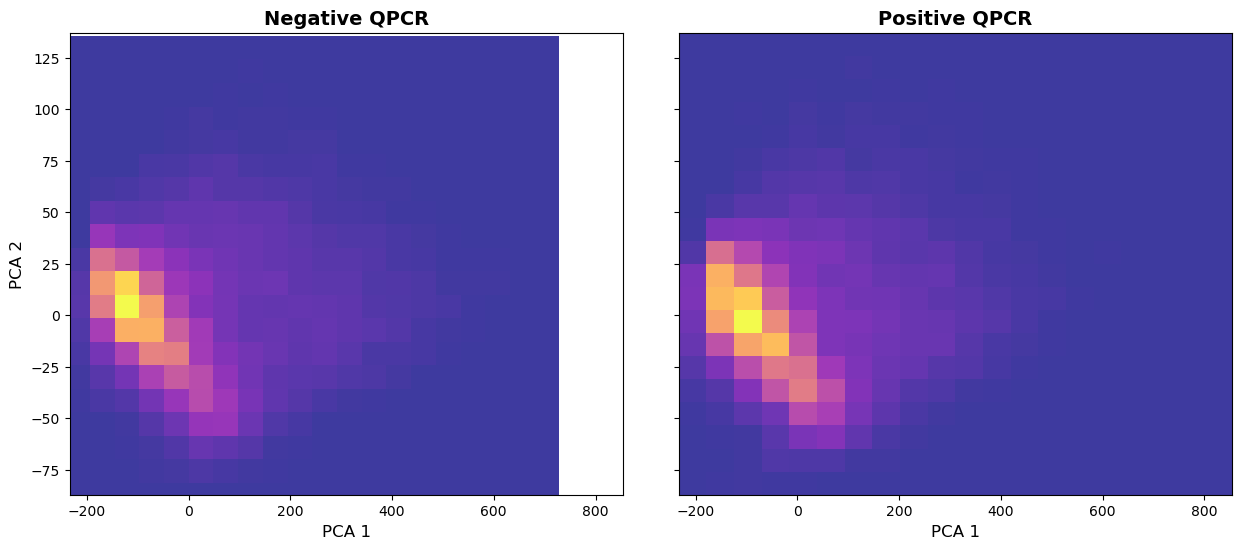

In [19]:
# Make a PCA of all the features except the PCR label and the ratio_red_NDVI2
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
mask = np.logical_and(df.columns != 'PCR', df.columns != 'ratio_red_NDVI2')
pca.fit(df.loc[:, mask])

# make 2 subplots with histograms 2d with pca transformation with matplotlib
# first subplot is the histogram of PCR value 0
# second subplot is the histogram of PCR value 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

# Set titles and labels
ax1.set_title('Negative QPCR', fontsize=14, fontweight='bold')
ax1.set_xlabel('PCA 1', fontsize=12)
ax1.set_ylabel('PCA 2', fontsize=12)
ax2.set_title('Positive QPCR', fontsize=14, fontweight='bold')
ax2.set_xlabel('PCA 1', fontsize=12)

# Plot histograms with 2D PCA transformation
bins = 20
alpha = 0.8
cmap = 'plasma'
# norm = plt.Normalize(vmin=0, vmax=0.08)

a1 = ax1.hist2d(pca.transform(df.loc[df['PCR'] == 0, mask])[:, 0], 
                pca.transform(df.loc[df['PCR'] == 0, mask])[:, 1], 
                bins=bins, alpha=alpha, cmap=cmap)
a2 = ax2.hist2d(pca.transform(df.loc[df['PCR'] == 1, mask])[:, 0], 
                pca.transform(df.loc[df['PCR'] == 1, mask])[:, 1], 
                bins=bins, alpha=alpha, cmap=cmap)

# Include shared colorbar between ax1 and ax2. Use scientific notation
# cbar = fig.colorbar(a2[3], ax=[ax1, ax2], format='%.0e')
# cbar.ax.tick_params(labelsize=10)

# Adjust space between subplots and figure border
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# Save and show the plot
plt.savefig('histograms.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [20]:
# Train a SVC model with the PCA transformed data
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# split the data in train and test set
from sklearn.decomposition import PCA
pca = PCA(n_components=34)

mask = np.logical_and(df.columns != 'PCR', df.columns != 'ratio_red_NDVI2')
pca.fit(df.loc[:, mask])
X_train, X_test, y_train, y_test = train_test_split(pca.transform(df.loc[:, mask]), df['PCR'], test_size=0.2, random_state=0)

# Train a SVC model with the PCA transformed data
svc = SVC(kernel='rbf', class_weight='balanced', random_state=0)
svc.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=0)

Accuracy:  0.5750573293349797
Confusion matrix:  [[1807 1689]
 [ 720 1453]]
f1_score 0.5467544684854186
precision_score 0.462444302991725
recall_score 0.6686608375517717
auc_score 0.5927686338788607


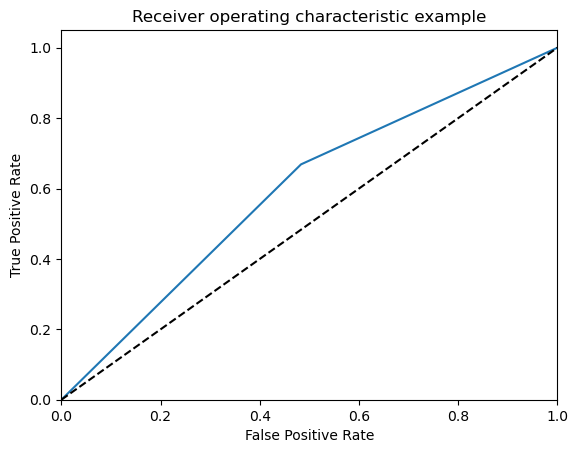

In [21]:
# predict the test set
y_pred = svc.predict(X_test)

# print the metrics
print('Accuracy: ', accuracy_score(y_test, y_pred))

# print the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))

# print the f1 score
print('f1_score', f1_score(y_test, y_pred))

# print the precision score
print('precision_score', precision_score(y_test, y_pred))

# print the recall score
print('recall_score', recall_score(y_test, y_pred))

# print the roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

# print the auc score
print('auc_score', auc(fpr, tpr))

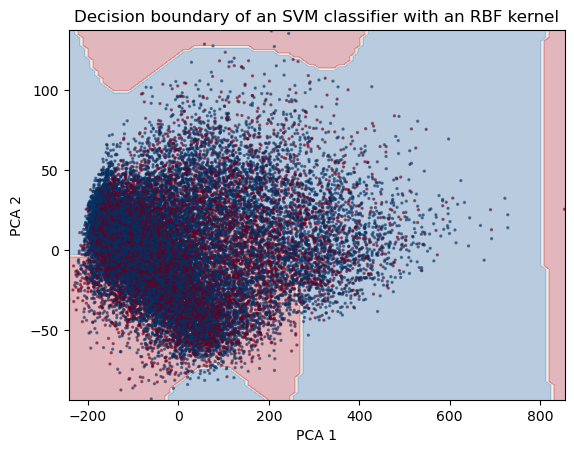

In [27]:
# Generate a grid of points to plot the decision boundary
X = pca.transform(df.loc[:, mask])
y = df['PCR']
X_2d = X[:, :2]

# Train a temporary 2D SVC for visualization
svc_2d = SVC(kernel='rbf', class_weight='balanced', random_state=0)
svc_2d.fit(X_2d, y)

x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = svc_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and the training points
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu_r, alpha=0.3)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap=plt.cm.RdBu_r, alpha=0.5, s=2)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Decision boundary of an SVM classifier with an RBF kernel')
plt.show()

## Load data

In [34]:
path = '/home/jgalvan/Desktop/Xylella fastidiosa detection/Coding/Main_file/Processed Data/QPCR_labelled_df_qpcr.pkl'
df = load_pickle(path)
df = df.dropna()
df

,C,B,G,Y,R,RE,N,N2,NDVI_1,NDVI_2,...,NPQI_4,NPQI_5,CLR,CLG,BNDVI,CTR1,cluster_id,Lats,Longs,PCR
62265,82.123163,72.863853,61.984130,59.086614,48.457757,58.281538,70.228826,43.539953,0.183433,-0.053456,...,0.104046,0.118719,0.204993,0.133013,-0.018415,0.590062,272,39.618125,2.583222,1.0
62266,107.312201,92.556787,76.681398,74.078740,57.804938,75.358655,91.938908,57.742825,0.227949,-0.000538,...,0.128712,0.146916,0.220018,0.198973,-0.003349,0.538661,272,39.618125,2.583228,1.0
62267,104.206703,87.633553,71.143297,70.198425,53.131348,73.948618,90.129735,58.557744,0.258258,0.048585,...,0.150594,0.171885,0.218816,0.266876,0.014042,0.509865,272,39.618125,2.583234,1.0
62268,109.037478,90.587493,73.060332,73.902362,55.345154,79.275425,95.557255,64.029342,0.266478,0.072747,...,0.161135,0.183925,0.205383,0.307923,0.026698,0.507579,272,39.618125,2.583239,1.0
62269,148.373783,124.721911,101.815856,105.121260,80.926914,112.489635,132.563077,90.223164,0.241867,0.054316,...,0.151146,0.172581,0.178447,0.301989,0.030477,0.545426,272,39.618125,2.583245,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777184,90.059436,78.443518,67.309227,50.091339,43.784166,78.335401,116.609456,73.691952,0.454041,0.254586,...,0.120103,0.137059,0.488592,0.732444,0.195670,0.486170,2407,39.614777,2.584997,0.0
777185,94.890210,84.679613,71.782309,53.971654,49.933628,81.155475,116.280515,75.088956,0.399165,0.201206,...,0.099094,0.113093,0.432812,0.619905,0.157250,0.526225,2407,39.614777,2.585003,0.0
777186,103.861648,94.197864,80.089460,62.085039,59.034831,87.735649,120.721214,78.930716,0.343167,0.144209,...,0.085064,0.097094,0.375965,0.507330,0.123411,0.568399,2407,39.614777,2.585009,0.0
777187,101.101205,93.541433,80.302464,66.318110,64.446357,84.288891,110.688525,72.411365,0.264037,0.058199,...,0.067708,0.077281,0.313204,0.378395,0.083960,0.637444,2407,39.614777,2.585015,0.0


In [35]:
df.columns

Index(['C', 'B', 'G', 'Y', 'R', 'RE', 'N', 'N2', 'NDVI_1', 'NDVI_2', 'ENDVI_1',
       'ENDVI_2', 'ratio_nir_red_1', 'ratio_nir_red_2', 'ratio_red_NDVI1',
       'ratio_red_NDVI2', 'BR3', 'BR4', 'GNDVI_1', 'GNDVI_2', 'SAVI_1',
       'SAVI_2', 'SAVI_3', 'SAVI_4', 'SAVI_5', 'SAVI_6', 'NPQI_1', 'NPQI_2',
       'NPQI_3', 'NPQI_4', 'NPQI_5', 'CLR', 'CLG', 'BNDVI', 'CTR1',
       'cluster_id', 'Lats', 'Longs', 'PCR'],
      dtype='object')

## Save real data for testing

In [36]:
df = df.sample(frac=1, random_state=42)
n_test = int(len(df)*0.05) # 5% of tree pixels for testing
n_train = len(df) - n_test
test_df = df.iloc[:n_test]
train_df = df.iloc[n_test:]

## Data preprocessing

In [37]:
#Data preprocessing: Normalization of spectral bands
# spectral_bands = ['C', 'B', 'G', 'Y', 'R', 'RE', 'N', 'N2']
# X_train = train_df.loc[:, spectral_bands] # only spectral bands
X_train = train_df.iloc[:, :-4] # spectral bands + indices
#X_train = train_df.iloc[:, 8:-4] # indices
X_test = test_df.iloc[:, :-4] 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_train = train_df['PCR'].values
Y_test = test_df['PCR'].values

In [38]:
n_features = X_train.shape[1]

print(Counter(Y_train))

Counter({0.0: 16485, 1.0: 10443})


## Balance the dataset using oversampling techniques

In [39]:
#random.seed(42)
#
#c = list(zip(X_train, Y_train))
#random.shuffle(c)
#X_train, Y_train = zip(*c)
#X_train = np.array(X_train)
#Y_train = np.array(Y_train)

# file_management.save_lzma(X_train, 'X_train.lzma', '')
# file_management.save_lzma(Y_train, 'Y_train.lzma', '')
# file_management.save_lzma(X_test, 'X_test.lzma', '')
# file_management.save_lzma(Y_test, 'Y_test.lzma', '')

## UMAP

In [40]:
from umap import UMAP

ModuleNotFoundError: No module named 'umap'

In [ ]:
X1 = X[5000:, :]
Y1 = Y[5000:]

X1.shape

(15833, 27)

In [ ]:
# Visualization
import plotly.express as px # for data visualization
import matplotlib.pyplot as plt # for showing handwritten digits

def chart(X, y):
    #--------------------------------------------------------------------------#
    # This section is not mandatory as its purpose is to sort the data by label 
    # so, we can maintain consistent colors for digits across multiple graphs
    
    # Concatenate X and y arrays
    arr_concat=np.concatenate((X, y.reshape(y.shape[0],1)), axis=1)
    # Create a Pandas dataframe using the above array
    df=pd.DataFrame(arr_concat, columns=['x', 'y', 'z', 'label'])
    # Convert label data type from float to integer
    df['label'] = df['label'].astype(int)
    # Finally, sort the dataframe by label
    df.sort_values(by='label', axis=0, ascending=True, inplace=True)
    #--------------------------------------------------------------------------#
    
    # Create a 3D graph
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), height=900, width=950)

    # Update chart looks
    fig.update_layout(title_text='UMAP',
                      showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=-1.4, z=0.5)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             ),
                                   yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                              ),
                                   zaxis=dict(backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             )))
    # Update marker size
    fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))
    fig.show()

## Train a simple neural network usign 7-fold validation

In [41]:
## Since there exist an unbalance in the dataset we perform some 
# over_sampling techniques (SMOTE)
from imblearn.over_sampling import ADASYN, RandomOverSampler

#ros = RandomOverSampler(random_state=42, ratio=1.0)
#X_train, Y_train = ros.fit_resample(X_train, Y_train)

adasyn = ADASYN(random_state=42)
# X_train, Y_train = adasyn.fit_resample(X_train, Y_train)

In [48]:
# =============================================================================
# ANN: 1 pixel = 1 tree
# =============================================================================

# Define the K-fold Cross Validator
num_folds = 7
#n_features = 27
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0) #fix the divition

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

#Set the training parameters
num_epochs = 200
verbosity = 1 #0:silent, 1:to show a progress bar during the training, 2:show results after each epoch

#initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
initializer = tf.keras.initializers.GlorotNormal(seed=42)

# Define the model architecture
def model():
    classifier = Sequential()
    # First layer
    classifier.add(Dense(units = 128, input_dim = n_features, kernel_initializer = initializer,  activation = "relu"))
    # Second layer
    classifier.add(Dense(units = 64, kernel_initializer = initializer,  activation = "relu"))
    #classifier.add(Dropout(rate = 0.2))
    # Third layer
    classifier.add(Dense(units = 32, kernel_initializer = initializer,  activation = "relu"))
    #classifier.add(Dropout(rate = 0.2))
    
    classifier.add(Dense(units = 8, kernel_initializer = initializer,  activation = "relu"))

    # Output layer
    classifier.add(Dense(units = 1, kernel_initializer = initializer,  activation = "sigmoid"))

    # Compilar la RNA
    classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
    return classifier

# def model():
#     classifier = Sequential()
#     # First layer
#     classifier.add(Dense(units = 1, input_dim = n_bands, kernel_initializer = "uniform",  activation = "sigmoid"))
    
#     # Compilar la RNA
#     classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
#     return classifier

In [45]:
# K-fold Cross Validation model evaluation
ground_acc = 0

fold_no = 1
for train, validate in kfold.split(X_train, Y_train):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    classifier = model()
    
    # Oversample the training set
    X_train_balanced, Y_train_balanced = adasyn.fit_resample(X_train[train], Y_train[train])
    X_val, Y_val = X_train[validate], Y_train[validate]
    n_training_examples = X_train_balanced.shape[0]

    # Fit data to model    
    history = classifier.fit(X_train_balanced, Y_train_balanced, 
                             validation_data = (X_val, Y_val), 
                             batch_size = n_training_examples, epochs = num_epochs, verbose=verbosity)

    # Generate generalization metrics
    scores = classifier.evaluate(X_val, Y_val, verbose=0)
    print(f'Score for fold {fold_no}: {classifier.metrics_names[0]} of {scores[0]}; {classifier.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    if scores[1]>ground_acc:
        ground_acc = scores[1]
        classifier.save('ann_classifier_best_new.h5')
        #file_management.save_lzma(train, 'train_set.lzma', '')
        file_management.save_lzma(validate, 'validate_set.lzma', '')
        train_set = train
        validate_set = validate
        
        train_acc2 = history.history['accuracy']
        val_acc2 = history.history['val_accuracy']
        train_loss2 = history.history['loss']
        val_loss2 = history.history['val_loss']
            
    # Increase fold number
    fold_no = fold_no + 1


# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)} (+- {np.std(loss_per_fold)})')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/500
1/1 [==============================] - 1s 943ms/step - loss: 0.6936 - accuracy: 0.4960 - val_loss: 0.6929 - val_accuracy: 0.5573
Epoch 2/500
1/1 [==============================] - 0s 34ms/step - loss: 0.6931 - accuracy: 0.5011 - val_loss: 0.6926 - val_accuracy: 0.6054
Epoch 3/500
1/1 [==============================] - 0s 41ms/step - loss: 0.6931 - accuracy: 0.4975 - val_loss: 0.6926 - val_accuracy: 0.6036
Epoch 4/500
1/1 [==============================] - 0s 47ms/step - loss: 0.6931 - accuracy: 0.4978 - val_loss: 0.6928 - val_accuracy: 0.5766
Epoch 5/500
1/1 [==============================] - 0s 45ms/step - loss: 0.6931 - accuracy: 0.5040 - val_loss: 0.6929 - val_accuracy: 0.5550
Epoch 6/500
1/1 [==============================] - 0s 43ms/step - loss: 0.6930 - accuracy: 0.5178 - val_loss: 0.6930 - val_accuracy: 0.5214
Epoch 7/500
1/1 [==============================] - 0s 38ms/ste

/home/jgalvan/.local/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/500
1/1 [==============================] - 1s 521ms/step - loss: 0.6937 - accuracy: 0.4979 - val_loss: 0.6929 - val_accuracy: 0.5641
Epoch 2/500
1/1 [==============================] - 0s 33ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6925 - val_accuracy: 0.5979
Epoch 3/500
1/1 [==============================] - 0s 35ms/step - loss: 0.6931 - accuracy: 0.4975 - val_loss: 0.6925 - val_accuracy: 0.6018
Epoch 4/500
1/1 [==============================] - 0s 33ms/step - loss: 0.6931 - accuracy: 0.4993 - val_loss: 0.6925 - val_accuracy: 0.6015
Epoch 5/500
1/1 [==============================] - 0s 34ms/step - loss: 0.6931 - accuracy: 0.4991 - val_loss: 0.6926 - val_accuracy: 0.5960
Epoch 6/500
1/1 [==============================] - 0s 43ms/step - loss: 0.6931 - accuracy: 0.4992 - val_loss: 0.6926 - val_accuracy: 0.5877
Epoch 7/500
1/1 [==============================] - 0s 40ms/step - loss: 0.6930 - accuracy: 0.5037 - val_loss: 0.6926 - val_accuracy: 0.5794
Epoch 8/500
1/1 [==

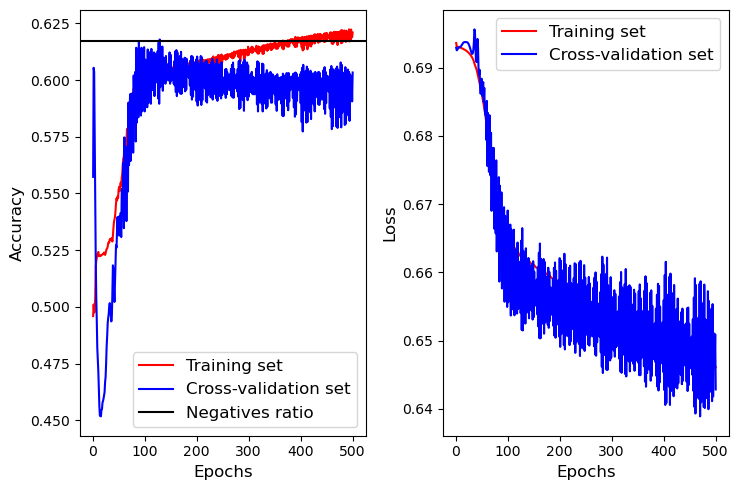

In [47]:
# =============================================================================
# DRAW THE LEARNING CURVES FOR THE BEST K-FOLD
# =============================================================================
#classifier = model()
# history = classifier.fit(X[train_set], Y[train_set], validation_data = (X[test_set], Y[test_set]), batch_size = number_examples, epochs = num_epochs, verbose=verbosity)
# train_acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']
epochs = np.arange(1, num_epochs+1)

fig, (ax1, ax2) = plt.subplots(1
                               
                               ,2, figsize=(7.5, 5), sharex=True)
#Draw accuracy curve
ax1.plot(epochs, train_acc2, 'r-', label='Training set')
ax1.plot(epochs, val_acc2, 'b-', label='Cross-validation set')
ax1.axhline(1- sum(Y_train[validate_set])/len(Y_train[validate_set]), label='Negatives ratio', color='k')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.legend(loc='best', fontsize=12)
#Draw cost curve
ax2.plot(epochs, train_loss2, 'r-', label='Training set')
ax2.plot(epochs, val_loss2, 'b-', label='Cross-validation set')
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='best', fontsize=12)
plt.tight_layout()
# plt.savefig(os.path.join(classification_path, 'ann_learning_curves3.png'), dpi=300, transparent=True)

In [52]:
# =============================================================================
# CONFUSSION MATRIX FOR THE BEST CLASSIFIER OVER VALIDATION SET
# =============================================================================
# Load the best classifier
# best_model_path = 'Classification figures/num_epochs_25000_oversampling_True_dropout_True '
# best_model = keras.models.load_model(os.path.join(best_model_path, 'ann_classifier_best_new.h5'))
best_model = keras.models.load_model('ann_classifier_best_new.h5')

#train_set = file_management.load_lzma('train_set.lzma')
validate_set = file_management.load_lzma('validate_set.lzma')
# We evaluate the best classifier on its fold
y_pred = best_model.predict(X_train[validate_set])

Y_pred = np.round(y_pred)
cm=confusion_matrix(Y_train[validate_set],Y_pred)
print(cm)

121/121 [==============================] - 0s 466us/step
[[1336 1039]
 [ 487  985]]


In [53]:
# =============================================================================
# OBTAIN ACCURACY, RECALL, PRECISION, F1SCORE FOR BEST MODEL
# =============================================================================
# Evalute its accuracy over the last kfold
accuracy = accuracy_score(Y_train[validate_set], Y_pred)
recall = recall_score(Y_train[validate_set], Y_pred)
precision = precision_score(Y_train[validate_set], Y_pred)
f1score = f1_score(Y_train[validate_set], Y_pred)
print("Accuracy: %.2f%%" % (accuracy*100))
print("Recall: %.2f%%" % (recall*100))
print("Precision: %.2f%%" % (precision*100))
print("F1-score: %.2f%%" % (f1score*100))
print("Proportion of positives: %.2f%%" %(100*sum(Y_train[validate_set]/len(Y_train[validate_set]))))

Accuracy: 60.33%
Recall: 66.92%
Precision: 48.67%
F1-score: 56.35%
Proportion of positives: 38.26%


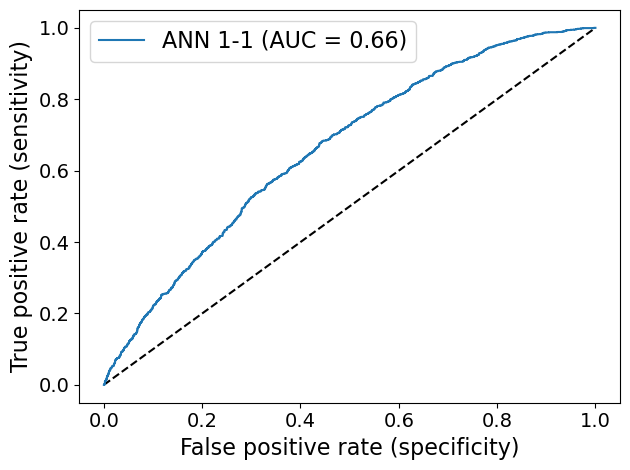

In [55]:
# =============================================================================
# ROC and AUC
# =============================================================================
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_train[validate_set], y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ANN 1-1 (AUC = {:.2f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate (specificity)', fontsize=16)
plt.ylabel('True positive rate (sensitivity)', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# plt.savefig(os.path.join(classification_path, 'roc_curve_validation_ANN11.png'), dpi=300, transparent=True)

## Test set evaluation

In [57]:
# =============================================================================
# CONFUSSION MATRIX FOR THE BEST CLASSIFIER OVER TEST SET
# =============================================================================
# Load the best classifier
#best_model = keras.models.load_model('ann_classifier_best_new.h5')

# X_test = file_management.load_lzma('X_test.lzma')
# Y_test = file_management.load_lzma('Y_test.lzma')

# We evaluate the best classifier on its fold
y_test_pred = best_model.predict(X_test)

Y_test_pred = np.round(y_test_pred)
cm=confusion_matrix(Y_test,Y_test_pred)
print(cm)

45/45 [==============================] - 0s 475us/step
[[455 385]
 [173 404]]


In [58]:
# =============================================================================
# OBTAIN ACCURACY, RECALL, PRECISION, F1SCORE FOR BEST MODEL
# =============================================================================
# Evalute its metrics
accuracy = accuracy_score(Y_test, Y_test_pred)
recall = recall_score(Y_test, Y_test_pred)
precision = precision_score(Y_test, Y_test_pred)
f1score = f1_score(Y_test, Y_test_pred)
print("Accuracy: %.2f%%" % (accuracy*100))
print("Recall: %.2f%%" % (recall*100))
print("Precision: %.2f%%" % (precision*100))
print("F1-score: %.2f%%" % (f1score*100))
print("Proportion of positives: %.2f%%" %(100*sum(Y_test)/len(Y_test)))

Accuracy: 60.62%
Recall: 70.02%
Precision: 51.20%
F1-score: 59.15%
Proportion of positives: 40.72%


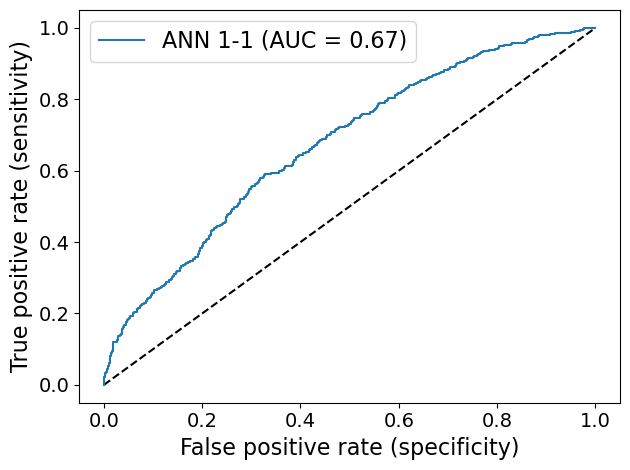

In [60]:
# =============================================================================
# ROC and AUC
# =============================================================================
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_test_pred)
auc_keras = auc(fpr_keras, tpr_keras)

fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ANN 1-1 (AUC = {:.2f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate (specificity)', fontsize=16)
plt.ylabel('True positive rate (sensitivity)', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# plt.savefig(os.path.join(classification_path, 'roc_curve_test_ANN11.png'), dpi=300, transparent=True)